In [1]:
# Import the functions used in this project
import awesome_functions as af

# Pretty display for notebooks
%matplotlib inline

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
submission = pd.read_csv("../asset/sample_submission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("submission  data : ", submission.shape)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle as pkl
slack_url = pkl.load(open("Slack_url/send_url.pickle", "rb"))

import xgboost
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import csr_matrix
def fitNaiveBayesModel(X, y):
    return MultinomialNB().fit(X, y)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy()
df_submission = submission.copy()

df_train_dd = pd.read_csv("Feature_matrix/df_train_dd_201807291831.csv")
df_test_dd = pd.read_csv("Feature_matrix/df_test_dd_201807291855.csv")
df_ratio = pd.read_csv("Feature_matrix/df_new_has_all_the_ratio_201808031807.csv")

Train data :  (647054, 7)
Test  data :  (653646, 6)
submission  data :  (95674, 39)


In [2]:
def checksum(x):
    try:
        odd = map(int, ','.join(x[-1::-2]).split(','))
        even = map(int, ','.join(x[-2::-2]).split(','))
        sum_odd3 = sum(odd) * 3
        total = sum_odd3 + sum(even)
        rem = total % 10
        if rem == 0:
            return rem
        return 10 - rem
    except:
        return 0

def full_upc(x):
    try:
        if len(x) < 12:
            missing = 11 - len(x)
            zeros = ['0'] * missing
            xx = zeros + ','.join(x).split(',') + [str(checksum(x))]
            xx = ''.join(xx)
            return xx
    except:
        return "-9999"

def company(x):
    try:
        p = x[:6]
        if p == '000000':
            if x == "000000-99990":
                return "000000"
            return x[7:-3]
        return p
    except:
        return "-9999"
    
def decodeStuffNeedsToBeDecoded(df_):
    df = df_.copy()
    col_list = ["FinelineNumber", "DepartmentDescription", "Upc"]
    replace_nan_list = ["1.1", "NULL", "-9999"]
    
    for col in col_list:
        col_idx = col_list.index(col)
        df[col] = df[col].astype(str)
        df[col] = df[col].apply(lambda a : a.split(".")[0] \
                                if a != "nan" else replace_nan_list[col_idx])
        if col_idx == 2:
            df[col] = df[col].apply(full_upc)
            df["Company"] = df[col].apply(company)
    return df

In [3]:
def getMostFrequentFeatureAsDf(df_, col):
    """
        df_ : df_train or df_test
        col : Most frequent item per visitnumber를 구하고자하는 컬럼명을 넣어준다. 
    """
    df = df_.copy()
    tmp_df = df.groupby(["VisitNumber", col]).agg({"ScanCount" : np.sum}).reset_index()
    mf_feature_li = []
    scancount_li = []
    for i, vn in enumerate(tmp_df.VisitNumber.unique()):
        tmp = tmp_df[tmp_df.VisitNumber == vn]
        max_count = tmp["ScanCount"].max()
        mf_feature = tmp[tmp["ScanCount"] == max_count][col].values[0]
        mf_feature_li.append(mf_feature)
        scancount_li.append(max_count)
        if i % 5000 == 0:
            print(str(i) + "까지 진행됨. " + str(95674 - i) + "개 남음.")
    key_value = "MF_" + col
    result_df = pd.DataFrame({key_value : mf_feature_li, "ScanCount" : scancount_li})
    return result_df

def concatDf(df_1, df_2):
    dd_cols = df_1.columns
    if ("MENS WEAR" in dd_cols) and ("MENSWEAR" in dd_cols):
        df_1["MENS WEAR"] = df_1["MENSWEAR"] + df_1["MENS WEAR"]
        df_1.drop("MENSWEAR", axis=1, inplace = True)
    return pd.concat([df_1, df_2], axis = 1)

def concatMenswear(df):
    df["MENS WEAR"] = df["MENSWEAR"] + df["MENS WEAR"]
    return df.drop("MENSWEAR", axis=1)

In [4]:
def getSpecifiedVisitNumberData(vn):
    display(df_train[df_train.VisitNumber == vn])
    display(df_train_dd[df_train_dd.VisitNumber == vn])

In [5]:
def getDummiesDf(df):
    dummie_col = df.columns[0]
    ItemNumber = df["ScanCount"]
    dummies_desc = pd.get_dummies(df[dummie_col])
    desc_cols = dummies_desc.columns
    result_df = dummies_desc.apply(lambda x: x * ItemNumber)
    result_df = pd.DataFrame(np.where(result_df < 0, 0, result_df), columns=result_df.columns)
    return result_df

In [6]:
df_decoded = decodeStuffNeedsToBeDecoded(df_train)

In [9]:
df_decoded.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,Company
0,999,5,Friday,681131529297,-1,FINANCIAL SERVICES,1000,681131
1,30,7,Friday,605388159809,1,SHOES,8931,605388
2,30,7,Friday,074108110992,1,PERSONAL CARE,4504,074108
3,26,8,Friday,022384035102,2,PAINT AND ACCESSORIES,3565,022384
4,26,8,Friday,020066137441,2,PAINT AND ACCESSORIES,1017,020066


In [14]:
train_tt = df_decoded.groupby(['TripType','VisitNumber']).size().reset_index()
train_tt_sc = train_tt.groupby('TripType',as_index=False)['VisitNumber'].count()

In [15]:
train_tt_sc.head()

,TripType,VisitNumber
0,3,3643
1,4,346
2,5,4593
3,6,1277
4,7,5752


In [19]:
df_decoded.groupby(["TripType", "ScanCount"]).count()

VisitNumber  Weekday    Upc  DepartmentDescription  \
TripType ScanCount                                                       
3        -4                   1        1      1                      1   
         -3                   2        2      2                      2   
         -2                   2        2      2                      2   
         -1                  49       49     49                     49   
          1                6395     6395   6382                   6395   
          2                 291      291    291                    291   
          3                  47       47     47                     47   
          4                  19       19     19                     19   
          5                   6        6      6                      6   
          6                   4        4      4                      4   
          7                   3        3      3                      3   
          8                   1        1      1                      1   
          9                   2        2      2                      2   
          10                  3        3      3                      3   
          11                  2        2      2                      2   
4        -1                   8        8      8                      8   
          1                 804      804    803                    804   
          2                  68       68     68                     68   
          3                  12       12     12                     12   
          4                   1        1      1                      1   
          5                   2        2      2                      2   
          6                   4        4      4                      4   
          8                   1        1      1                      1   
          25                  1        1      1                      1   
5        -3                   1        1      1                      1   
         -2                   6        6      6                      6   
         -1                 117      117    116                    117   
          1               12418    12418  12366                  12418   
          2                 970      970    969                    970   
          3                 163      163    163                    163   
...                         ...      ...    ...                    ...   
44        6                  26       26     26                     26   
          7                   6        6      6                      6   
          8                   6        6      6                      6   
          9                   2        2      2                      2   
          10                  5        5      5                      5   
          11                  1        1      1                      1   
          12                  4        4      4                      4   
          14                  2        2      2                      2   
999      -10                  1        1      1                      1   
         -7                   1        1      1                      1   
         -6                   8        8      8                      8   
         -5                  11       11     11                     11   
         -4                  54       54     54                     54   
         -3                  85       85     82                     85   
         -2                 493      493    486                    493   
         -1                9131     9131   8773                   9131   
          1                7074     7074   6977                   7074   
          2                 553      553    549                    553   
          3                  90       90     90                     90   
          4                  52       52     51                     52   
          5                  13       13     12                     13   
          6             

In [ ]:
import seaborn as sns
plt.figure(figsize=(30,10))
sns.barplot(train_tt_sc['TripType'].astype('int') , train_tt_sc['VisitNumber'])
# plt.ylim(-5000,50000)a

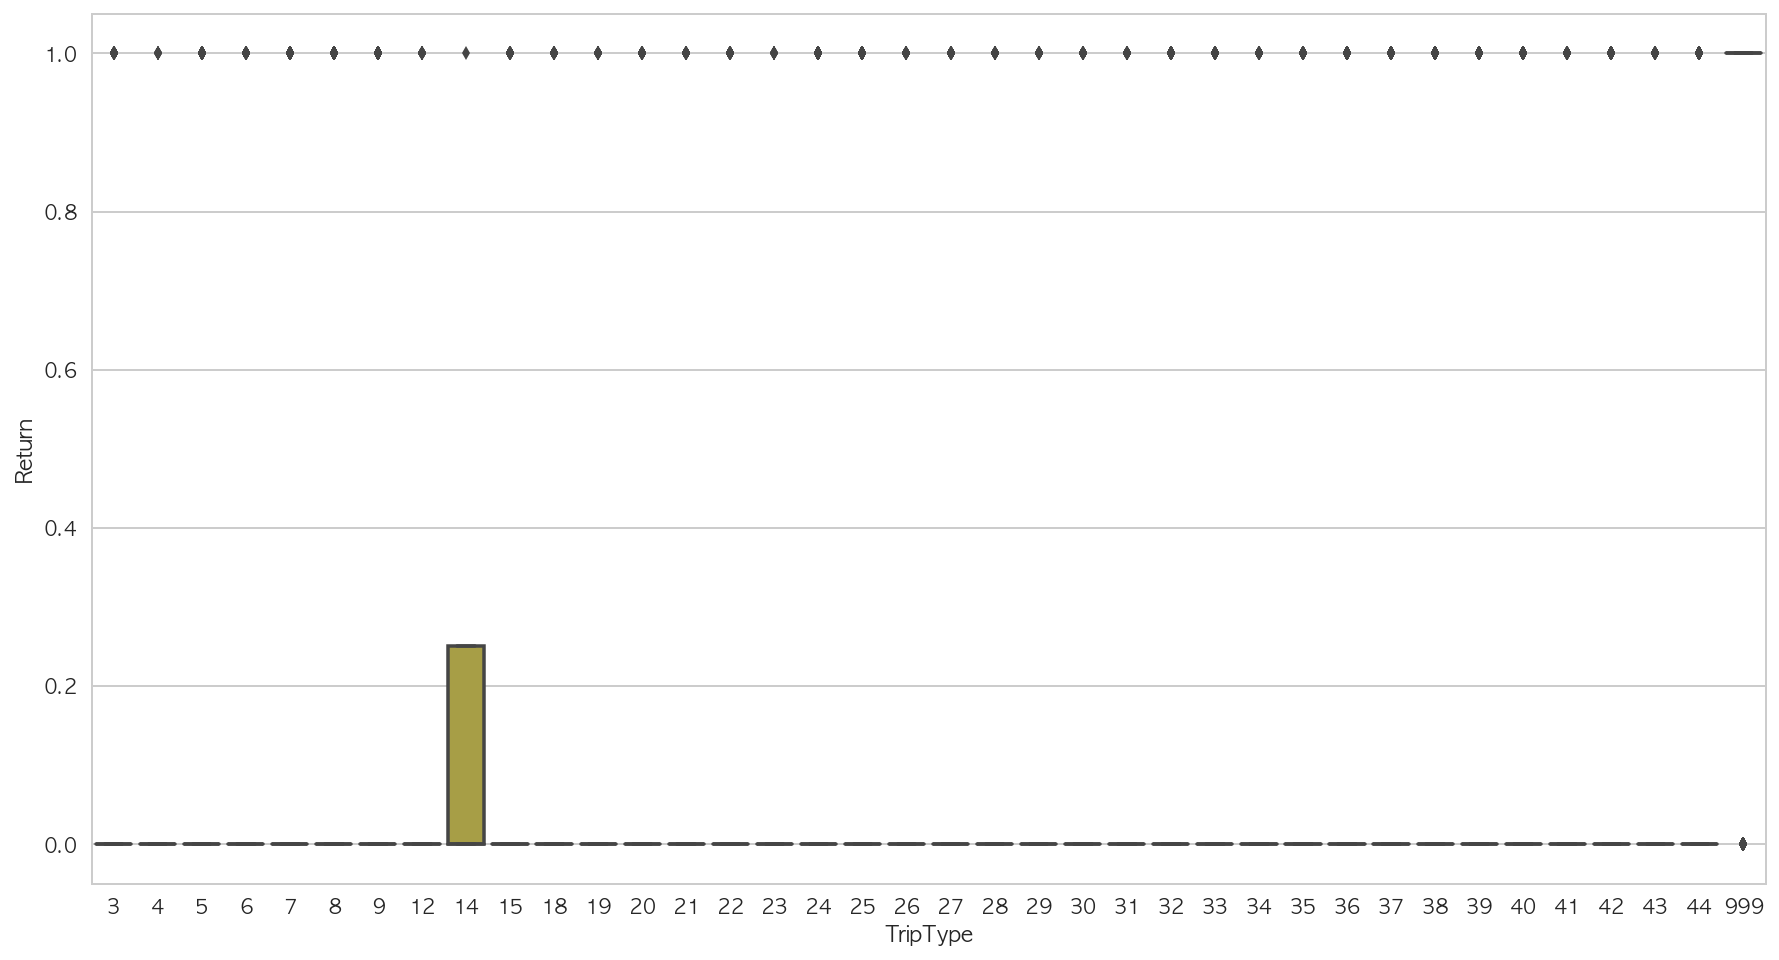

In [22]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="TripType", y="Return", data=df_train_dd)
plt.show()

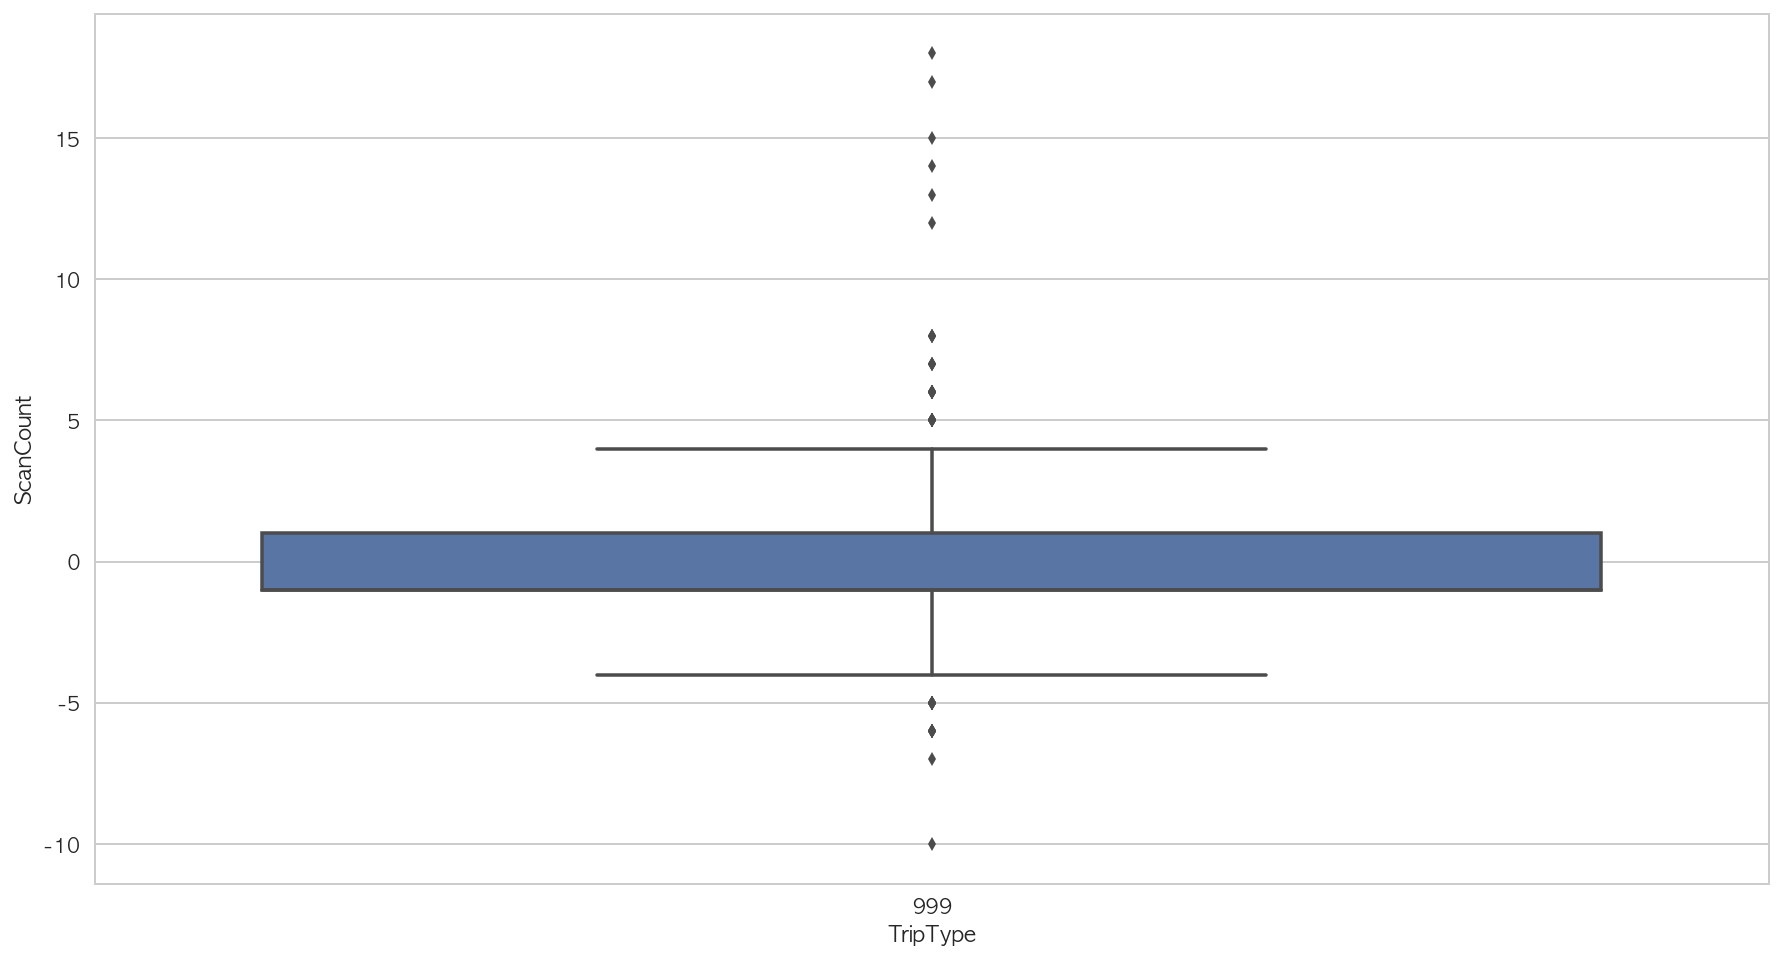

In [23]:
plt.figure(figsize=(15, 8))
sns.boxplot(x="TripType", y="ScanCount", data=df_decoded[df_decoded.TripType == 999])
plt.show()

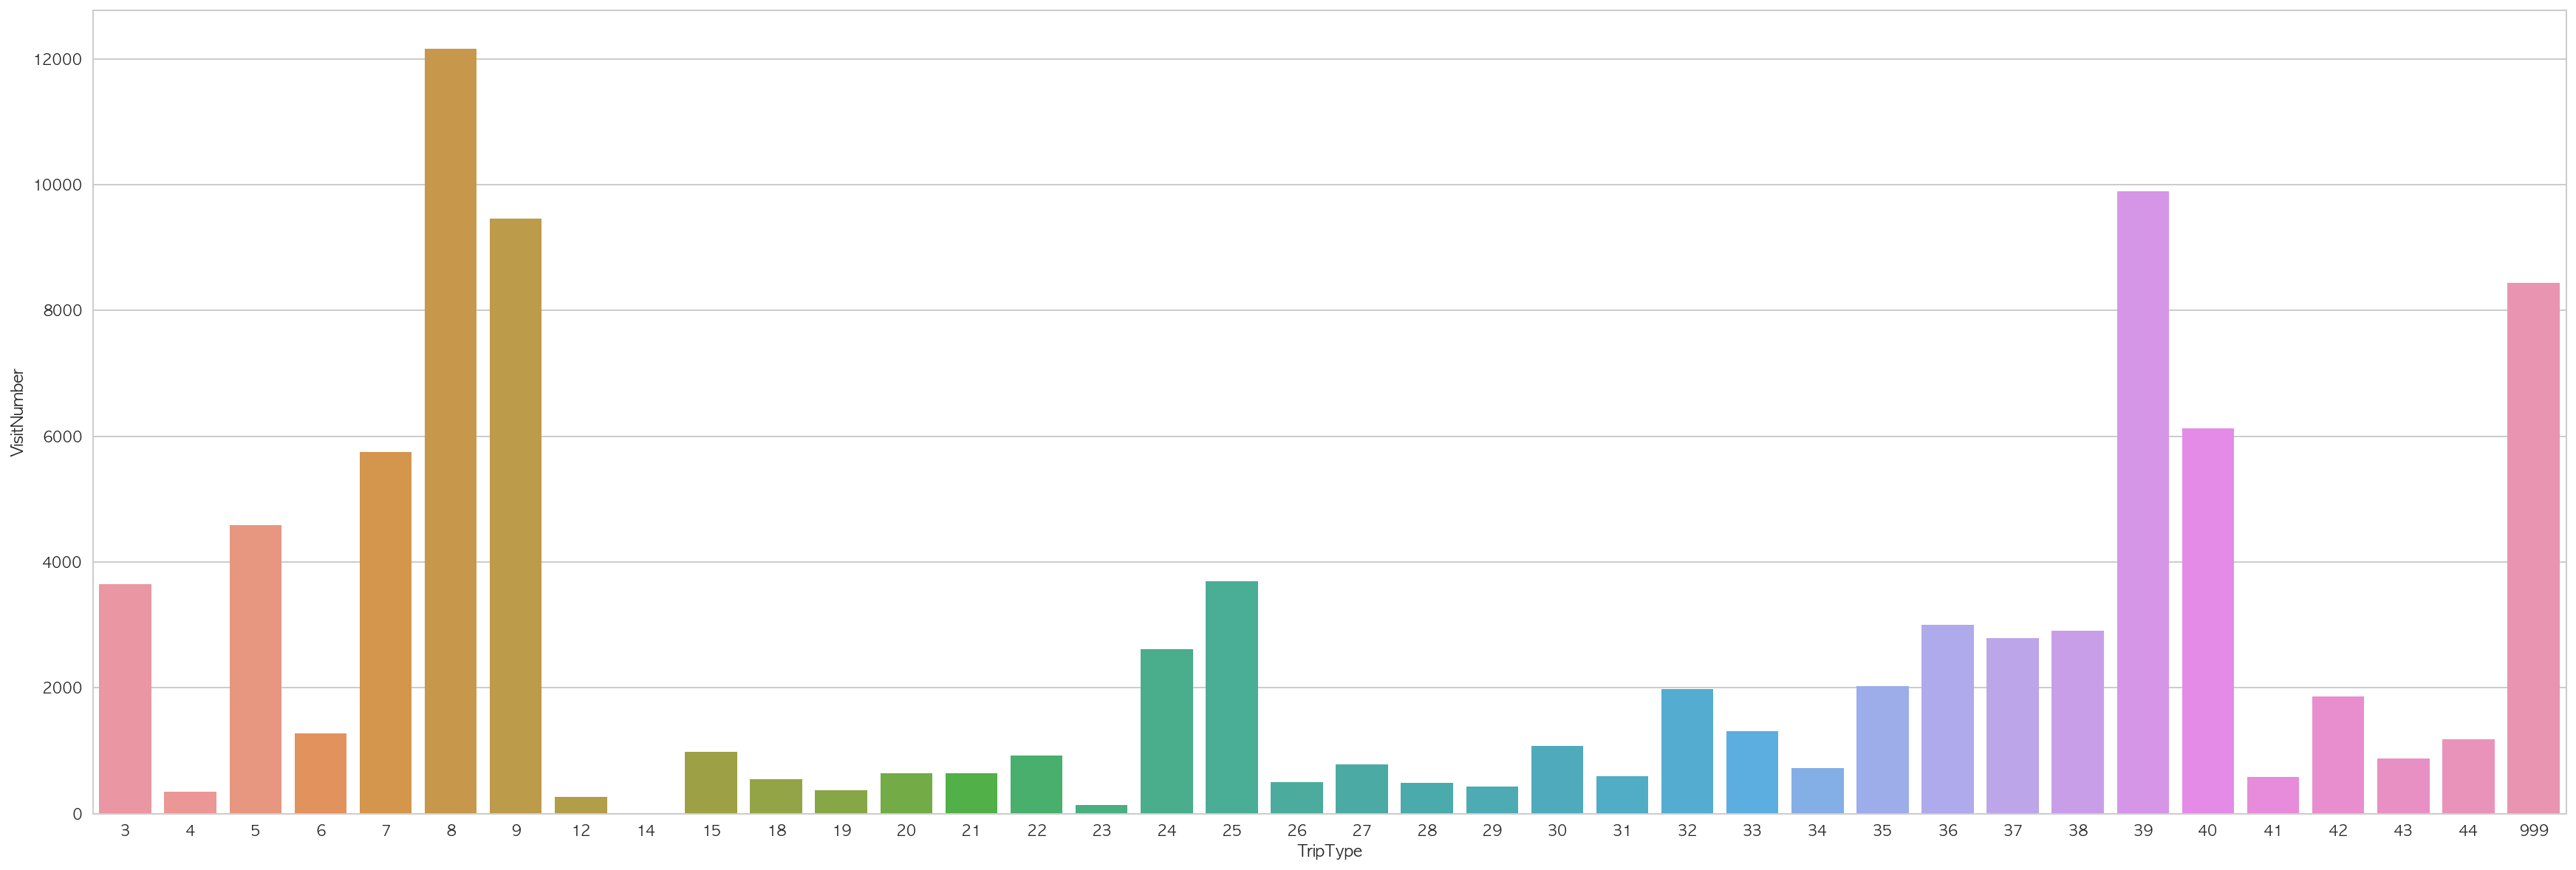

In [17]:
import seaborn as sns
plt.figure(figsize=(30,10))
sns.barplot(train_tt_sc['TripType'].astype('int') , train_tt_sc['VisitNumber'])
# plt.ylim(-5000,50000)

In [5]:
mf_fl = getMostFrequentFeatureAsDf(df_decoded, "FinelineNumber")
# mf_dd = getMostFrequentFeatureAsDf(df_decoded, "DepartmentDescription")
mf_company = getMostFrequentFeatureAsDf(df_decoded, "Company")
# mf_upc = getMostFrequentFeatureAsDf(df_decoded, "Upc")

0까지 진행됨. 95674개 남음.
5000까지 진행됨. 90674개 남음.
10000까지 진행됨. 85674개 남음.
15000까지 진행됨. 80674개 남음.
20000까지 진행됨. 75674개 남음.
25000까지 진행됨. 70674개 남음.
30000까지 진행됨. 65674개 남음.
35000까지 진행됨. 60674개 남음.
40000까지 진행됨. 55674개 남음.
45000까지 진행됨. 50674개 남음.
50000까지 진행됨. 45674개 남음.
55000까지 진행됨. 40674개 남음.
60000까지 진행됨. 35674개 남음.
65000까지 진행됨. 30674개 남음.
70000까지 진행됨. 25674개 남음.
75000까지 진행됨. 20674개 남음.
80000까지 진행됨. 15674개 남음.
85000까지 진행됨. 10674개 남음.
90000까지 진행됨. 5674개 남음.
95000까지 진행됨. 674개 남음.
0까지 진행됨. 95674개 남음.
5000까지 진행됨. 90674개 남음.
10000까지 진행됨. 85674개 남음.
15000까지 진행됨. 80674개 남음.
20000까지 진행됨. 75674개 남음.
25000까지 진행됨. 70674개 남음.
30000까지 진행됨. 65674개 남음.
35000까지 진행됨. 60674개 남음.
40000까지 진행됨. 55674개 남음.
45000까지 진행됨. 50674개 남음.
50000까지 진행됨. 45674개 남음.
55000까지 진행됨. 40674개 남음.
60000까지 진행됨. 35674개 남음.
65000까지 진행됨. 30674개 남음.
70000까지 진행됨. 25674개 남음.
75000까지 진행됨. 20674개 남음.
80000까지 진행됨. 15674개 남음.
85000까지 진행됨. 10674개 남음.
90000까지 진행됨. 5674개 남음.
95000까지 진행됨. 674개 남음.
0까지 진행됨. 95674개 남음.
5000까지 진행됨. 90674개 남음.
10000까지 진행됨. 

In [25]:
mf_fl_test = getMostFrequentFeatureAsDf(df_test_decoded, "FinelineNumber")
mf_company_test = getMostFrequentFeatureAsDf(df_test_decoded, "Company")

0까지 진행됨. 95674개 남음.
5000까지 진행됨. 90674개 남음.
10000까지 진행됨. 85674개 남음.
15000까지 진행됨. 80674개 남음.
20000까지 진행됨. 75674개 남음.
25000까지 진행됨. 70674개 남음.
30000까지 진행됨. 65674개 남음.
35000까지 진행됨. 60674개 남음.
40000까지 진행됨. 55674개 남음.
45000까지 진행됨. 50674개 남음.
50000까지 진행됨. 45674개 남음.
55000까지 진행됨. 40674개 남음.
60000까지 진행됨. 35674개 남음.
65000까지 진행됨. 30674개 남음.
70000까지 진행됨. 25674개 남음.
75000까지 진행됨. 20674개 남음.
80000까지 진행됨. 15674개 남음.
85000까지 진행됨. 10674개 남음.
90000까지 진행됨. 5674개 남음.
95000까지 진행됨. 674개 남음.
0까지 진행됨. 95674개 남음.
5000까지 진행됨. 90674개 남음.
10000까지 진행됨. 85674개 남음.
15000까지 진행됨. 80674개 남음.
20000까지 진행됨. 75674개 남음.
25000까지 진행됨. 70674개 남음.
30000까지 진행됨. 65674개 남음.
35000까지 진행됨. 60674개 남음.
40000까지 진행됨. 55674개 남음.
45000까지 진행됨. 50674개 남음.
50000까지 진행됨. 45674개 남음.
55000까지 진행됨. 40674개 남음.
60000까지 진행됨. 35674개 남음.
65000까지 진행됨. 30674개 남음.
70000까지 진행됨. 25674개 남음.
75000까지 진행됨. 20674개 남음.
80000까지 진행됨. 15674개 남음.
85000까지 진행됨. 10674개 남음.
90000까지 진행됨. 5674개 남음.
95000까지 진행됨. 674개 남음.


In [26]:
mf_fl_test_dummies = getDummiesDf(mf_fl_test)

In [27]:
mf_company_test_dummies = getDummiesDf(mf_company_test)

In [53]:
af.saveDataFrameToCsv(mf_fl, "mf_fl_train")
af.saveDataFrameToCsv(mf_company, "mf_company_train")

In [55]:
af.saveDataFrameToCsv(mf_fl_test, "mf_fl_test")
af.saveDataFrameToCsv(mf_company_test, "mf_company_test")

In [29]:
df_test = concatDf(df_test_dd, mf_fl_test_dummies)

In [30]:
df_test = concatDf(df_test, mf_company_test_dummies)

In [31]:
X_test = af.get_df_to_fit(df_test, True)

In [35]:
X_test.drop("index", axis = 1, inplace=True)

In [56]:
X_test.columns

Index(['Return', '1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY',
       'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES',
       'BOYS WEAR',
       ...
       '898078', '898115', '898628', '898999', '899053', '899407', '899539',
       '899792', '95', '98'],
      dtype='object', length=8161)

In [7]:
mf_fl_dummies = getDummiesDf(mf_fl)

In [8]:
mf_company_dummies = getDummiesDf(mf_company)

In [9]:
df_train = concatDf(df_train_dd, mf_fl_dummies)

In [10]:
df_train = concatDf(df_train, mf_company_dummies)

In [11]:
X, y = af.get_df_to_fit(df_train)

In [12]:
X.columns

Index(['Return', '1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY',
       'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES',
       'BOYS WEAR',
       ...
       '898078', '898115', '898628', '898639', '898999', '899407', '899539',
       '899675', '95', '98'],
      dtype='object', length=8096)

In [14]:
csr_train = csr_matrix(X)

In [16]:
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=7, objective="multi:softprob", n_jobs=4, learning_rate=0.2, eval_metric="mlogloss")

In [17]:
model_xgb.fit(csr_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
y_pred_1 = model_xgb.predict(csr_train)

In [22]:
y_pred_proba = model_xgb.predict_proba(csr_train)

In [23]:
log_loss(y, y_pred_proba)

0.5979328327168911

In [19]:
af.getAccuracy(y, y_pred_1, len(X))

##### Accuracy : 0.8206

In [21]:
print(classification_report(y, y_pred_1))

             precision    recall  f1-score   support

          3       0.95      0.97      0.96      3643
          4       0.84      0.76      0.80       346
          5       0.81      0.92      0.86      4593
          6       0.87      0.92      0.90      1277
          7       0.79      0.79      0.79      5752
          8       0.82      0.87      0.84     12161
          9       0.80      0.80      0.80      9464
         12       0.90      0.61      0.73       269
         14       1.00      0.75      0.86         4
         15       0.81      0.64      0.71       978
         18       0.68      0.71      0.70       549
         19       0.85      0.76      0.80       375
         20       0.81      0.80      0.81       637
         21       0.84      0.80      0.82       641
         22       0.75      0.76      0.75       928
         23       0.89      0.84      0.86       139
         24       0.76      0.81      0.78      2609
         25       0.82      0.87      0.85   

In [57]:
category_cnt = pd.read_csv("Feature_matrix/category_count.csv")

In [61]:
category_cnt.drop("vn", axis=1, inplace=True)

In [68]:
df_train = train.copy()

In [75]:
sc_total = df_train.groupby("VisitNumber").sum()["ScanCount"].reset_index(name="SC_Total")

In [76]:
sc_total.drop("VisitNumber", axis = 1, inplace=True)

In [63]:
df_new_dd = concatDf(df_train_dd, category_cnt)

In [77]:
df_new_dd = concatDf(df_new_dd, sc_total)

In [79]:
X, y = af.get_df_to_fit(df_new_dd)

In [80]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder().fit(y)
y_labeled = label_enc.transform(y)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labeled, random_state=0)

In [82]:
dtrain = xgb.DMatrix(X_train.values, label=y_train)
dtest = xgb.DMatrix(X_test.values, label=y_test)

In [83]:
num_boost_round = 300
params = {'objective': 'multi:softprob', 
          'eval_metric': 'mlogloss',
          'num_class':38, 
          'max_delta_step': 3, 
          'eta': 0.2}

evals = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(params=params,  
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                evals=evals,
                early_stopping_rounds=10,)

[0]	train-mlogloss:3.0732	eval-mlogloss:3.082
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:2.56934	eval-mlogloss:2.5889
[2]	train-mlogloss:2.17581	eval-mlogloss:2.20655
[3]	train-mlogloss:1.89203	eval-mlogloss:1.93096
[4]	train-mlogloss:1.70131	eval-mlogloss:1.74664
[5]	train-mlogloss:1.5602	eval-mlogloss:1.61129
[6]	train-mlogloss:1.45014	eval-mlogloss:1.5063
[7]	train-mlogloss:1.36103	eval-mlogloss:1.42181
[8]	train-mlogloss:1.28573	eval-mlogloss:1.35111
[9]	train-mlogloss:1.22311	eval-mlogloss:1.29336
[10]	train-mlogloss:1.17032	eval-mlogloss:1.24455
[11]	train-mlogloss:1.12519	eval-mlogloss:1.20331
[12]	train-mlogloss:1.08678	eval-mlogloss:1.16857
[13]	train-mlogloss:1.05241	eval-mlogloss:1.13772
[14]	train-mlogloss:1.02333	eval-mlogloss:1.1121
[15]	train-mlogloss:0.996832	eval-mlogloss:1.08907
[16]	train-mlogloss:0.972933	eval-mlogloss:1.06877
[17]	train-mlo

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
# from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Y_train = lb.fit_transform(y_train)
Y_test = lb.fit_transform(y_test)

# y_pred = lb.inverse_transform(np.round(predictions))
# y_true = lb.inverse_transform(train_y)

In [ ]:
model1 = Sequential()
model1.add(Dense(10, input_dim=77, activation="sigmoid", kernel_initializer="glorot_uniform"))
model1.add(Dense(20, activation="sigmoid"))
model1.add(Dense(38, activation="softmax"))
model1.compile(optimizer=Adagrad(lr=1.1), loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=100, batch_size=1000, validation_data=(X_test, Y_test), verbose=1)

In [83]:
af.getAccuracy(y, y_pred_1, len(X))

##### Accuracy : 0.933

In [75]:
model_xgb.fit(csr_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [76]:
y_pred = model_xgb.predict(csr_train)

In [77]:
af.getAccuracy(y, y_pred, len(X))

##### Accuracy : 0.6716

In [78]:
log_loss(y, model_xgb.predict_proba(csr_train))

1.0898283312467638